[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer.

We've also shown a number of ways to trim or filter messages in graph state.

## Goals

Now, let's take it one step further!

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.

This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_groq

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


In [34]:
from langchain_groq import ChatGroq
model = llm = ChatGroq(model="llama-3.3-70b-versatile",
                      api_key = os.environ.get("GROQ_API_KEY"),
                      temperature = 0
)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [5]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [7]:
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [8]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions.

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

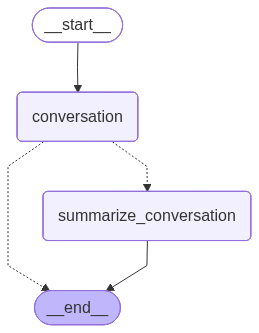

In [9]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [10]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hey Lance! 👋 Great to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Lance. How can I assist you today?
================================== Ai Message ==================================

That’s awesome! The 49ers have a rich history and some exciting talent on the roster.  

- **Current stars:** Brock Purdy, Deebo Samuel, Nick Bosa, and the ever‑reliable kicker Robbie Gould.  
- **All‑time legends:** Joe Montana, Jerry Rice, Ronnie Lott, and Steve Young.  

Do you have a favorite player, a memorable game, or a particular season that you love most? Let’s chat about the gold rush!


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`.

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [11]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [12]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

You’re right—Nick Bosa is definitely up there among the highest‑paid defenders in the league, and for a good chunk of the 2024‑2025 seasons he actually **holds the top spot**.

### Why Bosa’s contract is so big
| Year | Contract Details | Avg. Annual Value (AAV) |
|------|------------------|------------------------|
| **2022** (5‑year extension) | $170 million total, $115 million guaranteed | **$34 million per year** |
| **2024‑2025 seasons** | Still under that extension (year 3 & 4) | $34 million AAV |

- The $34 million AAV makes him the **most‑expensive defensive player on a per‑year basis** as of the 2024‑2025 NFL season.
- The deal also includes a $30 million roster bonus in 2025 and a $10 million workout bonus in 2024, which push his cash earnings even higher in those years.

### How he stacks up against other elite defenders (2024‑2025)

| Player | Position | Contract (AAV) | Current Status |
|----

In [13]:
graph.get_state(config).values.get("summary","")

'**Conversation Summary**\n\n| Turn | Speaker | Key Points |\n|------|---------|------------|\n| 1 | User (Lance) | Introduced himself. |\n| 2 | Assistant | Acknowledged Lance and asked how to help. |\n| 3 | User | Mentioned he likes the 49ers. |\n| 4 | Assistant | Responded enthusiastically, listed 49ers stars, legends, and asked about favorite player/season. |\n| 5 | User | Said he likes Nick\u202fBosa and asked if Bosa is the highest‑paid defensive player. |\n| 6 | Assistant | Confirmed Bosa holds the top spot for defensive players (2024‑2025) with a $34\u202fM average annual value (AAV) from his 5‑year, $170\u202fM extension. Provided a table comparing Bosa’s contract to other elite defenders, explained why the 49ers paid that amount, and added a few 49ers‑related trivia bits. |\n| 7 | User | Requested a summary of the conversation. |\n| 8 | Assistant | Delivered this concise summary. |'

## LangSmith

Let's review the trace!

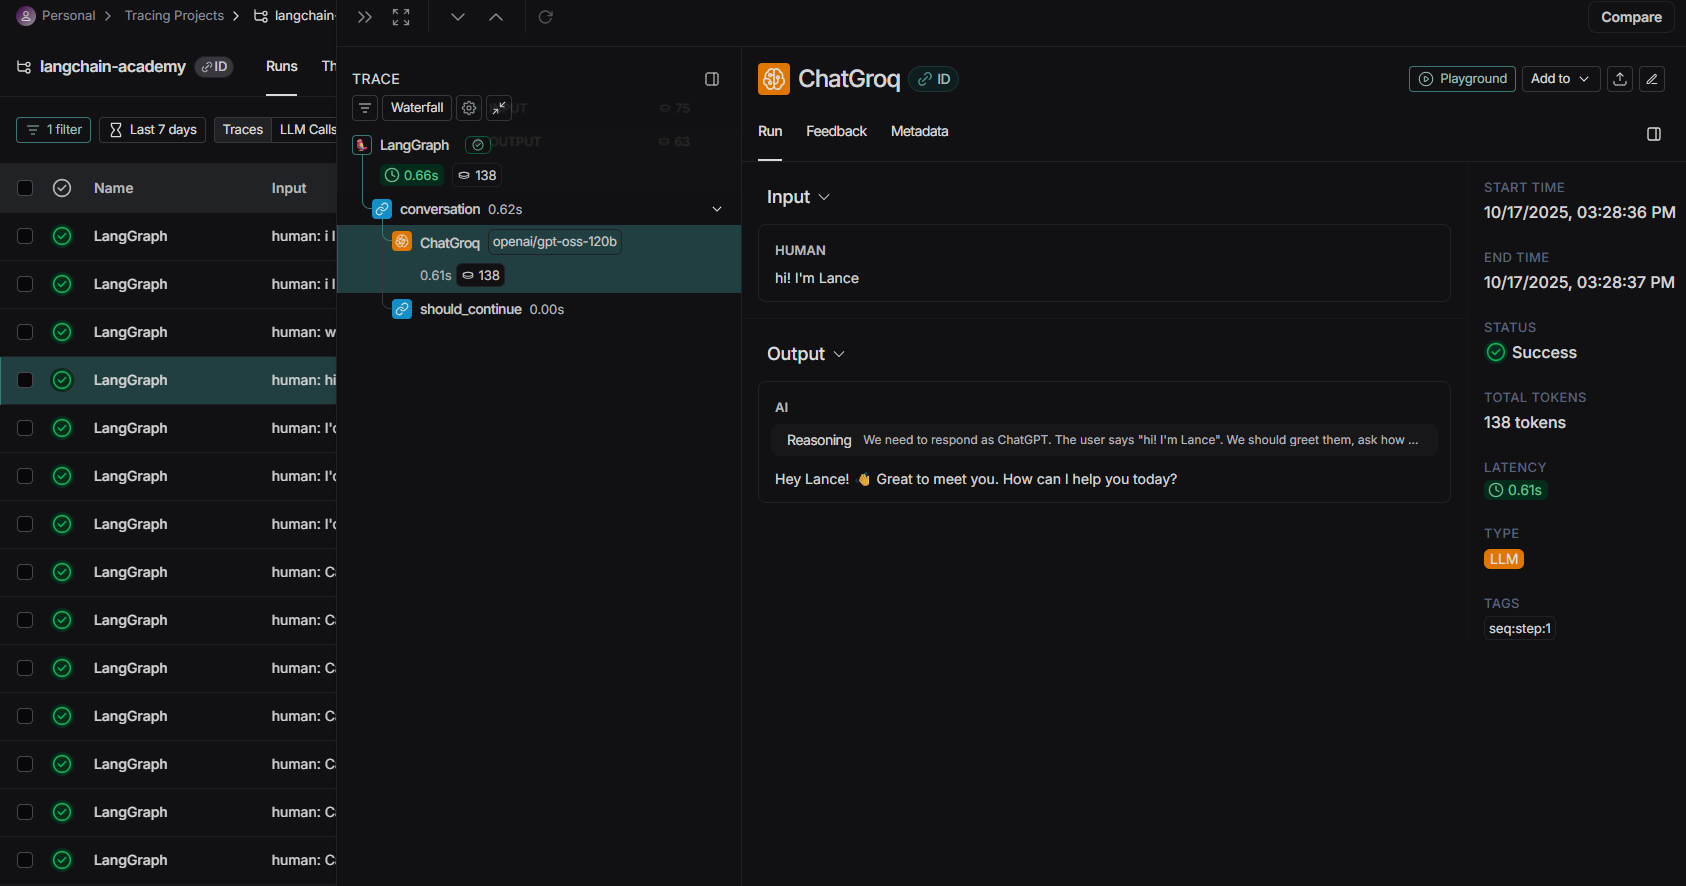

From here on, the model keeps the previous conversations in its memory:

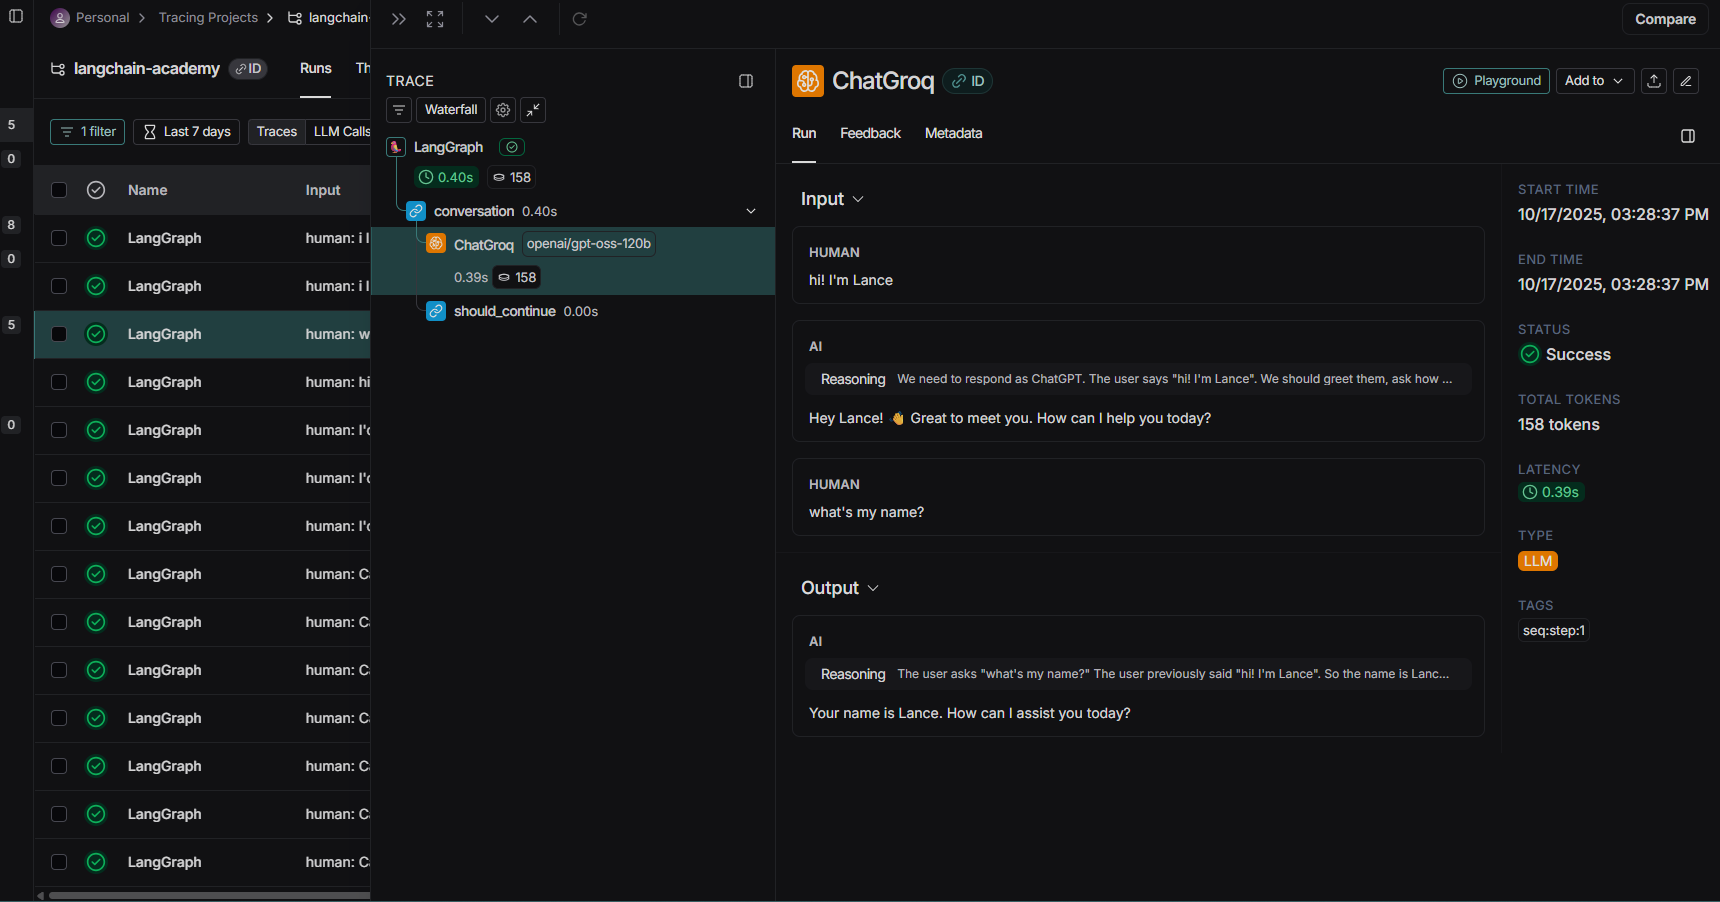

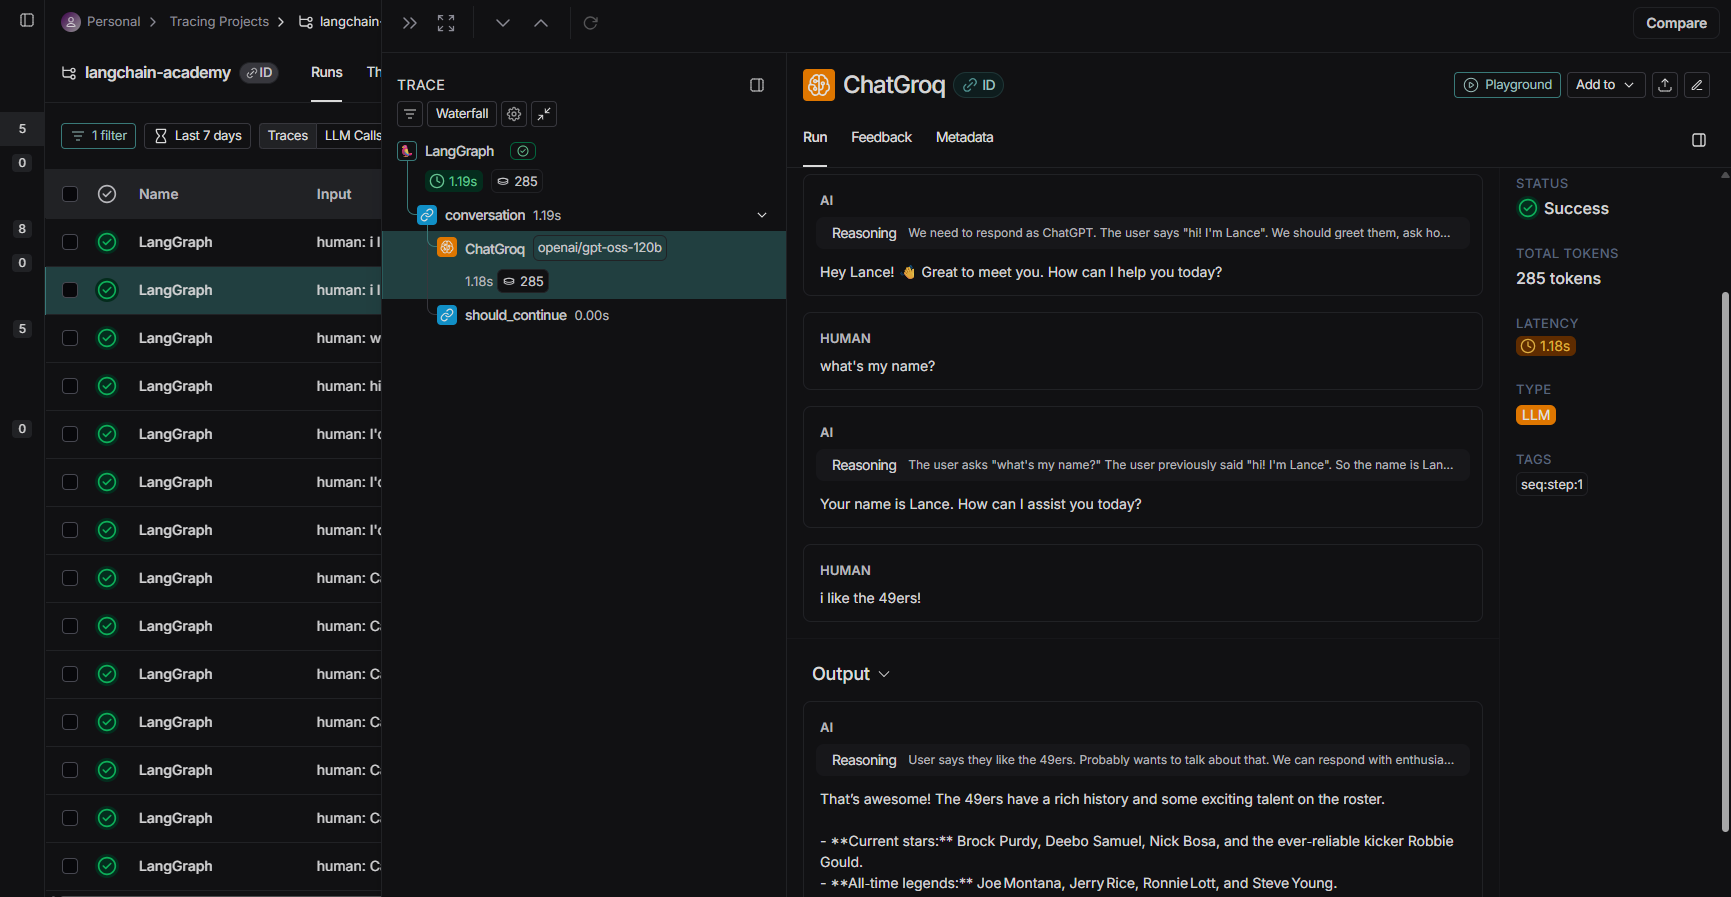

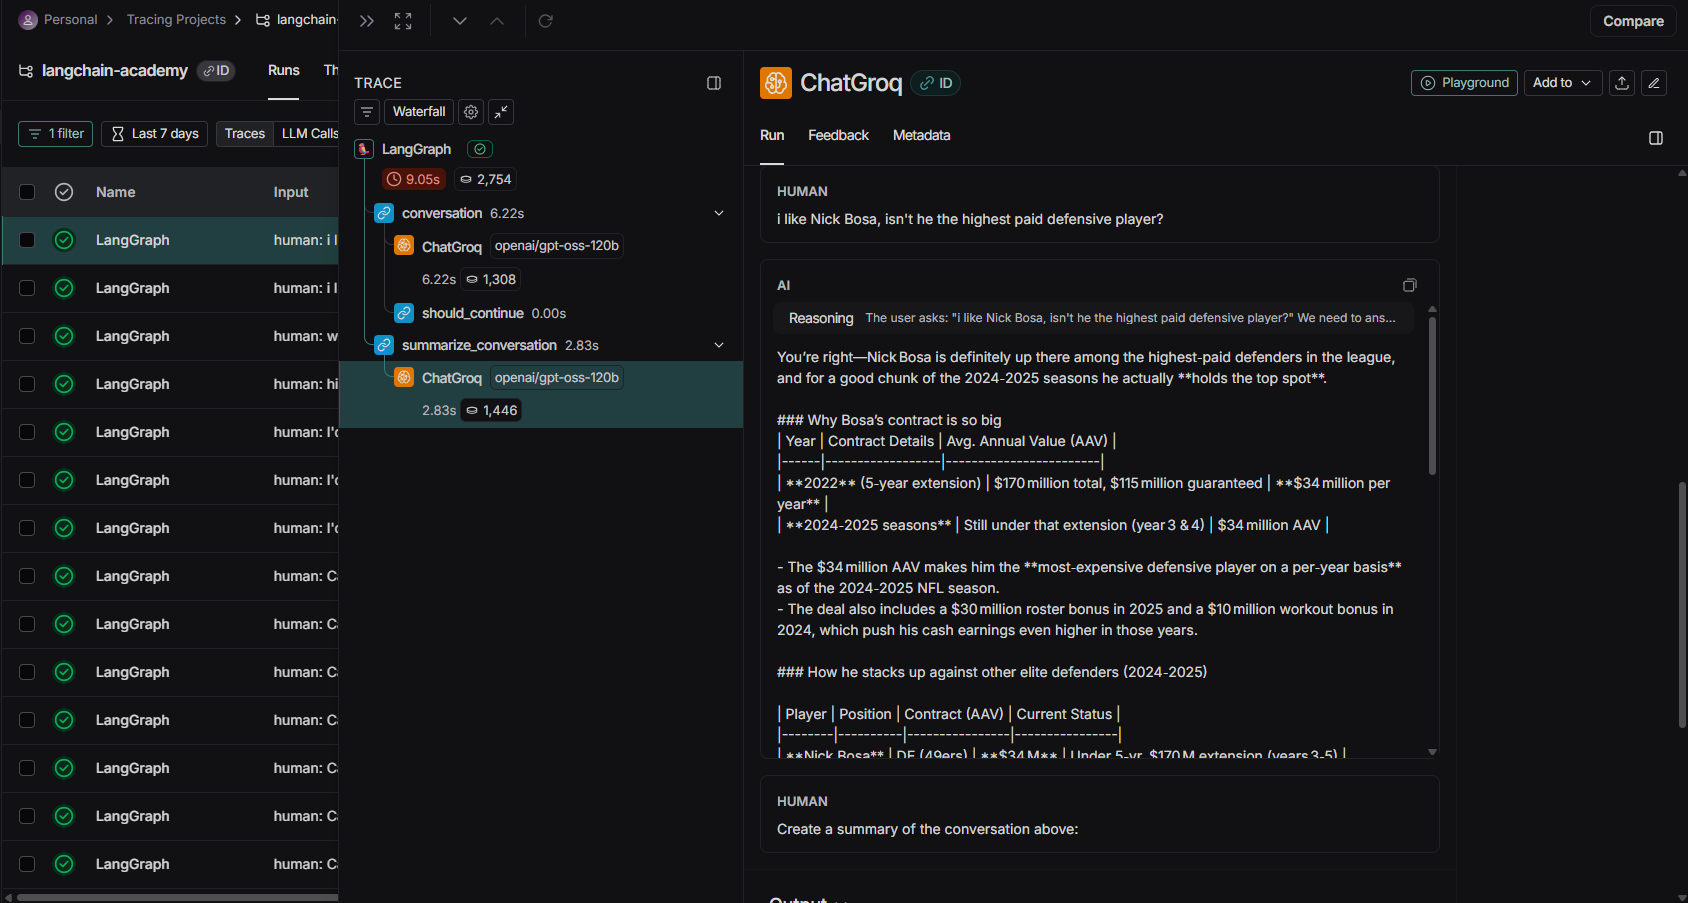

The summary of that output:

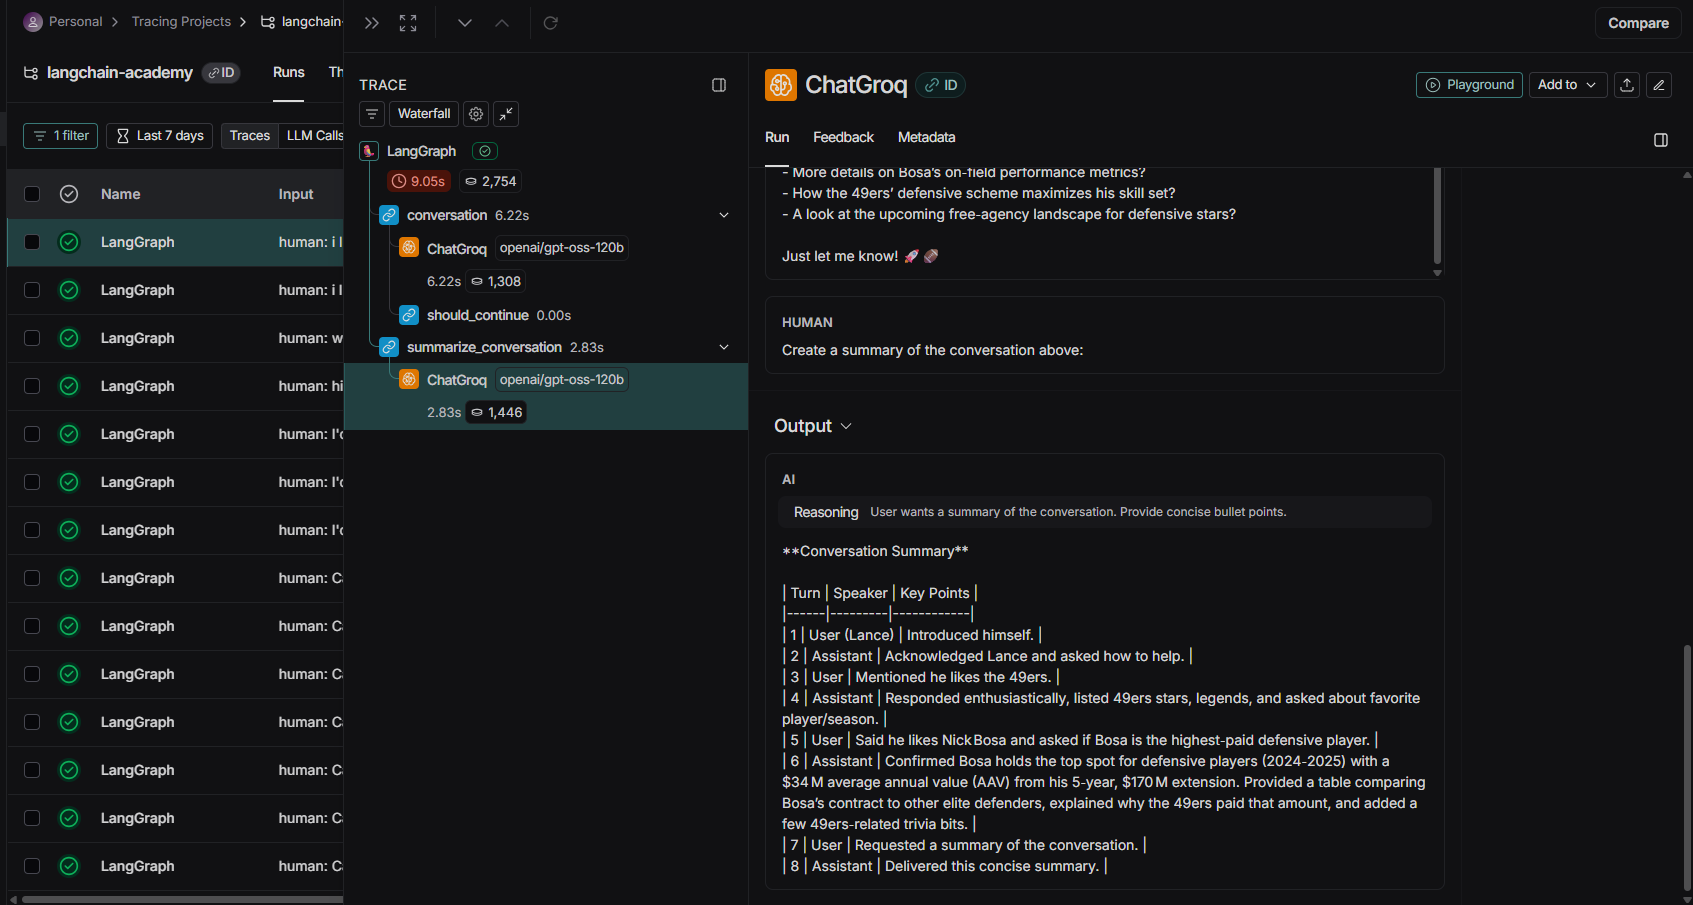

# MY EXAMPLES:

We'll define the `State` with `messages` and `summary` keys.

In [28]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

This node will include the summary in the prompt if it exists.

In [29]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

This node generates a summary and removes older messages.

In [30]:
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

This function determines whether to summarize based on the number of messages.

In [31]:
from langgraph.graph import END
from typing_extensions import Literal

def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    messages = state["messages"]
    if len(messages) > 4: # Summarize if more than 4 messages (changed from 6)
        return "summarize_conversation"
    return END

We'll use `MemorySaver` for persistence.

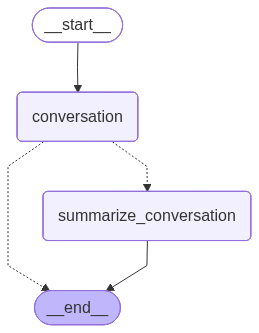

In [32]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation) # Corrected node name

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END) # Summarize node leads to END

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This is a workaround for a known issue with mermaid drawing on some systems
    print(f"Could not draw mermaid diagram: {e}")
    print("Workflow nodes:", workflow.nodes)
    print("Workflow edges:", workflow.edges)

Let's have a conversation to demonstrate the summarization and memory. We'll use a new thread ID.

In [37]:
# Create a new thread
config = {"configurable": {"thread_id": "my_custom_thread"}}

# Sample conversation
messages = [
    HumanMessage(content="Hello, I'm interested in learning about large language models."),
    HumanMessage(content="Can you tell me about some popular ones?"),
    HumanMessage(content="What are their main differences?"),
    HumanMessage(content="How can I fine-tune a large language model?"),
    HumanMessage(content="What are some challenges in fine-tuning?"),
]

# Invoke the graph with the messages
for i, msg in enumerate(messages):
    print(f"\n--- User Message {i+1} ---")
    print(msg.content)
    output = graph.invoke({"messages": [msg]}, config)
    print(f"\n--- AI Response {i+1} ---")
    for m in output['messages'][-1:]:
        m.pretty_print()

    # Check for summary after each turn
    current_summary = graph.get_state(config).values.get("summary","")
    print(f"\nCurrent Summary: {current_summary}")


--- User Message 1 ---
Hello, I'm interested in learning about large language models.

--- AI Response 1 ---
================================== Ai Message ==================================

Large language models are a type of artificial intelligence (AI) designed to process and understand human language. They're a fascinating topic, and I'd be happy to introduce you to the world of large language models.

**What are large language models?**

Large language models are a type of neural network that uses natural language processing (NLP) to learn patterns and relationships in language. They're trained on vast amounts of text data, which enables them to generate human-like language, answer questions, and even create new content.

**How do large language models work?**

Large language models work by using a technique called deep learning, which involves training a neural network on a large dataset of text. The model learns to recognize patterns in language, such as grammar, syntax, and se

Here is the final summary of the last prompt observed on Langsmith traces:

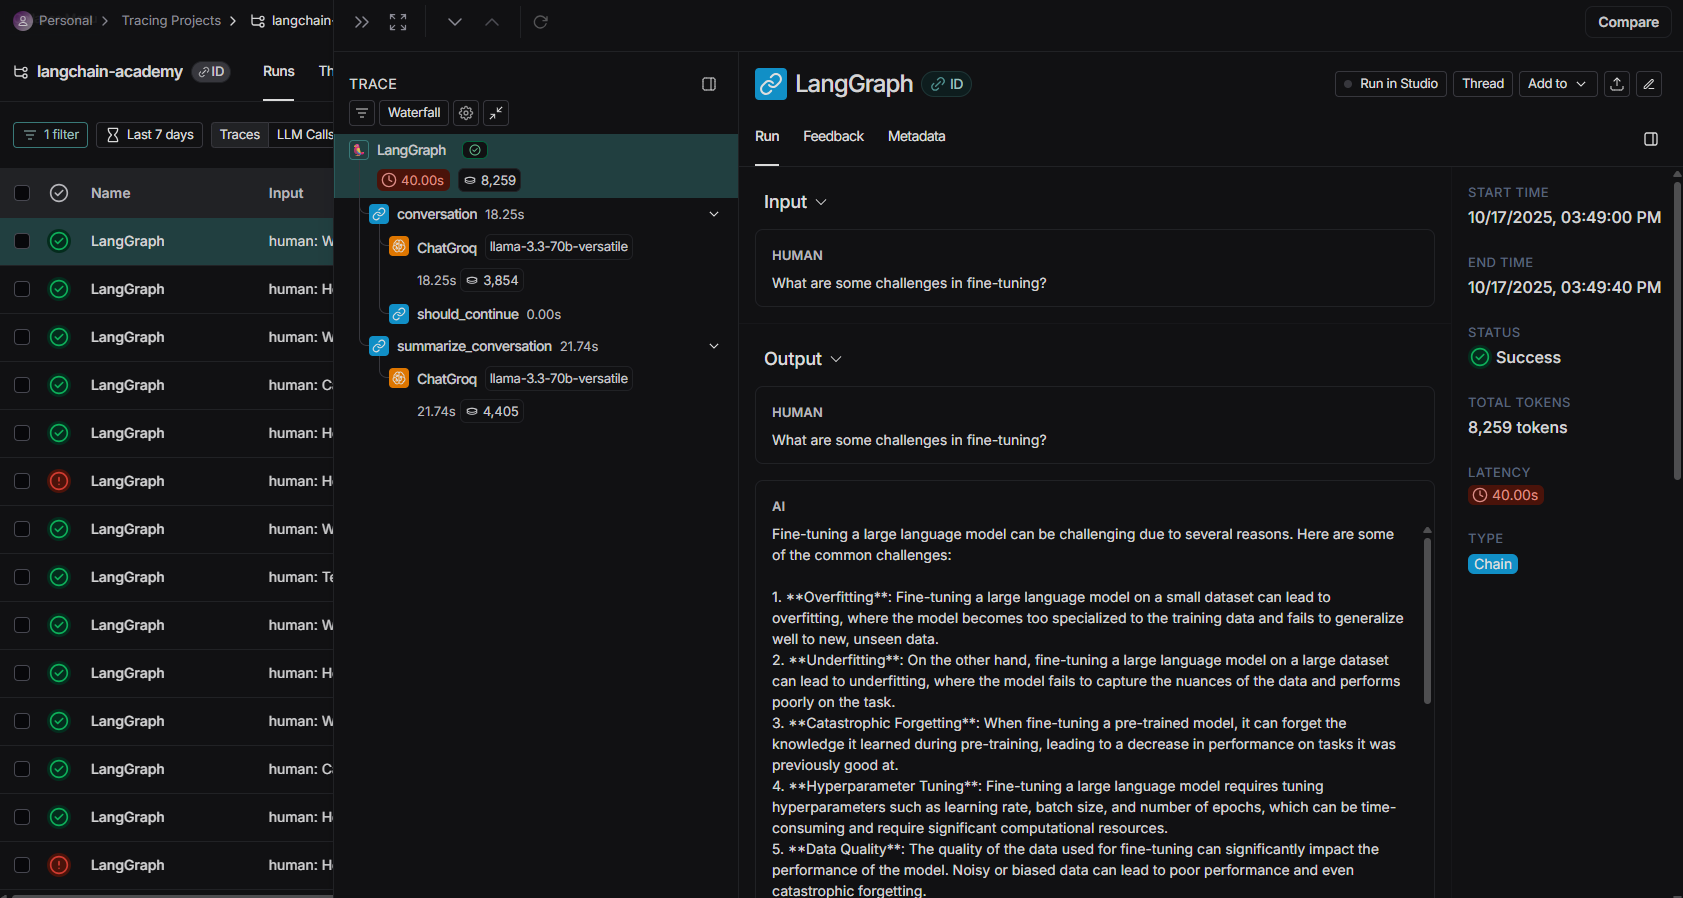

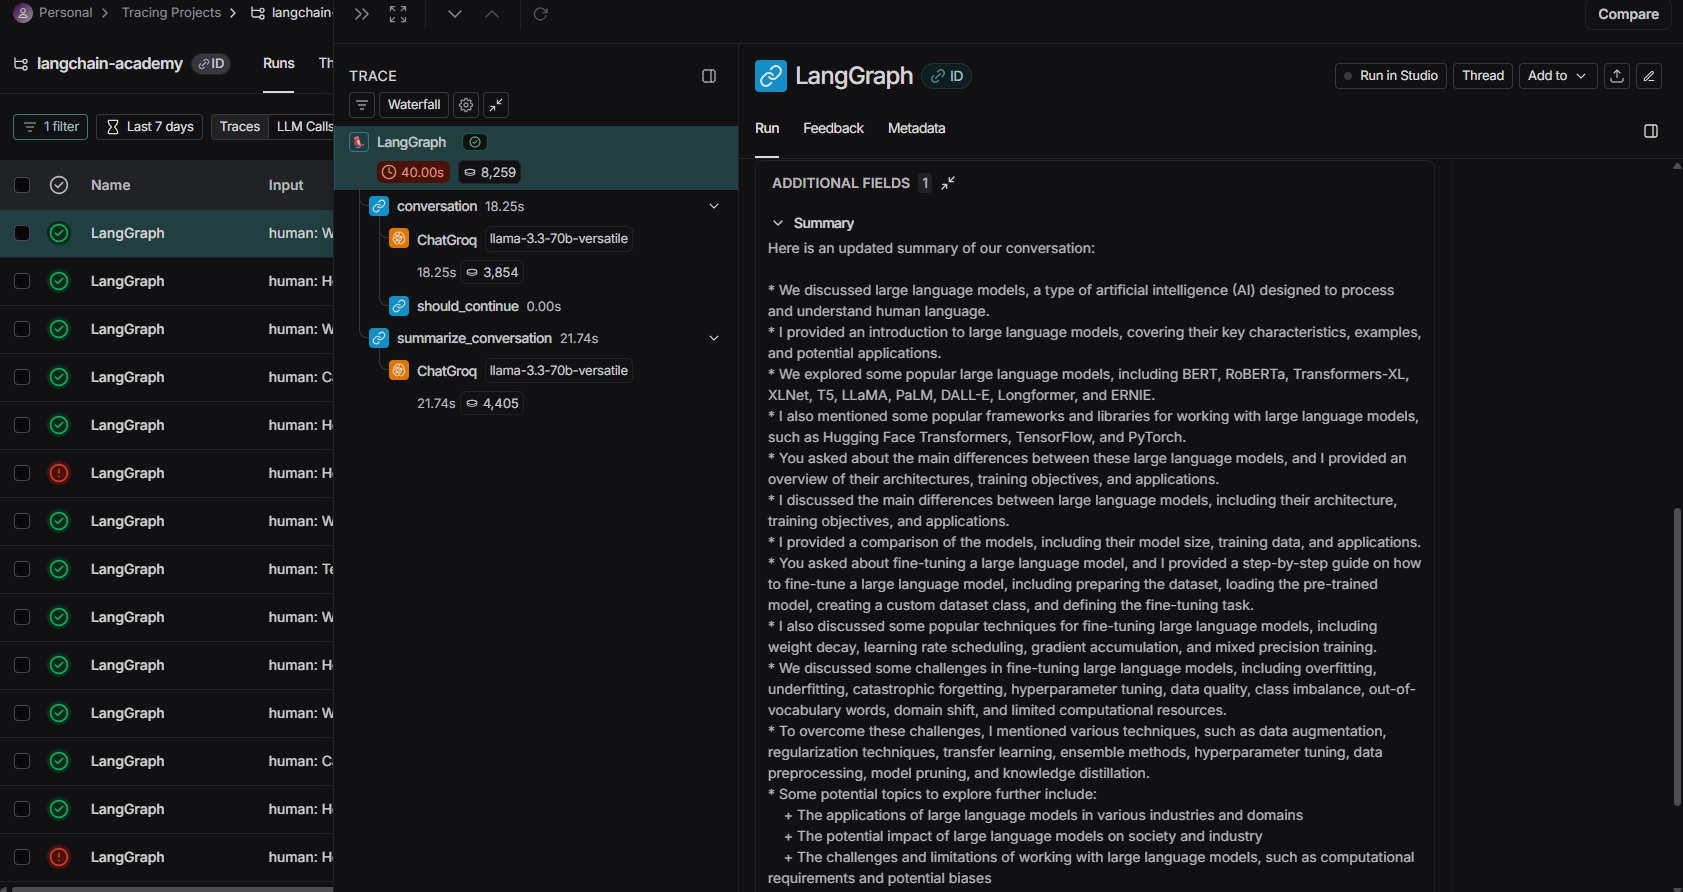